# Importing Libraries

In [179]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# importing geopy library and Nominatim class
from geopandas.tools import geocode
from geopy.geocoders import Nominatim

# Importing folium for visualization
import folium
from folium import Marker
from folium import Icon
from folium import CircleMarker

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

#### Install additional Packages

In [180]:
!pip install geopy
!pip install folium

In [181]:
plt.style.use('ggplot')

# Review the injection site and drop box locations

Begin exploration by reading the injection_site_locations.csv and needle_dropbox_locations.csv

The cvs's were derived from web scraping and HTML parsing from the "City of Toronto Web Parsing" notebook.

In [182]:
# Read the files into dataframes
needle_locations = pd.read_csv('needle_dropbox_locations.csv')
injection_locations = pd.read_csv('injection_site_locations.csv')

In [183]:
# Review the dataframe
needle_locations.head()

,Location Name,Address
0,The Works,277 Victoria St.
1,Casey House,119 Isabella St.
2,Dixon Hall,2714 Danforth Ave.
3,Eva's Satelite,25 Canterbury Place
4,Fred Victor,145 Queen St. E.


In [184]:
# Review the dataframe
injection_locations.tail()

,Location Name,Address
5,South Riverdale Community Health Centre \r\nKe...,955 Queen St. E.
6,Street Health,338 Dundas St. E.
7,Kensington Market Overdose Prevention Service,260 Augusta
8,Toronto Public Health The Works,277 Victoria St.
9,Casey House,119 Isabella St.


We must add "Toronto" to the address so if the address appears in a different location, Nominatim can locate the Toronto address.

In [187]:
# Add the term "Toronto" to the address
needle_locations['Address'] = needle_locations['Address'] + " Toronto"
injection_locations['Address'] = injection_locations['Address'] + " Toronto"

In [224]:
# Call the geocoding service Nominatim
locator = Nominatim(user_agent="Geopy Library")

# Function to output the Latitude and Longitude
def address_to_coordinates(address):

    # Increase timeout due to slow running
    Location = locator.geocode(address, timeout=10)

    # Return a tuple containing (lat, long)
    return Location.latitude, Location.longitude

# Apply the functions to the "Address" columns in the dataframe and unzip the tuple to get the latitude and logitude in seperate columns
needle_locations['Latitude'], needle_locations['Longitude'] = zip(*needle_locations['Address'].apply(lambda x: address_to_coordinates(x)))
injection_locations['Latitude'], injection_locations['Longitude'] = zip(*injection_locations['Address'].apply(lambda x: address_to_coordinates(x)))
injection_locations.head()


,Location Name,Address,Latitude,Longitude
0,Fred Victor,139 Jarvis St. Toronto,43.653638,-79.373080
1,Moss Park CTS,134 Sherbourne St. Toronto,43.650110,-79.367883
2,Parkdale Queen West Community Health Centre,168 Bathurst St. Toronto,43.646596,-79.404186
3,Parkdale Queen West Community Health Centre,1229 Queen St. W. Toronto,43.641821,-79.429519
4,"Regent Park Bevel Up CTS Site, Regent Park Com...",465 Dundas St. E. Toronto,43.659435,-79.365355


Lets review the new columns in the dataframe.

In [189]:
needle_locations.head()

,Location Name,Address,Latitude,Longitude
0,The Works,277 Victoria St. Toronto,43.656532,-79.379324
1,Casey House,119 Isabella St. Toronto,43.667948,-79.383837
2,Dixon Hall,2714 Danforth Ave. Toronto,43.689113,-79.298146
3,Eva's Satelite,25 Canterbury Place Toronto,43.772806,-79.414749
4,Fred Victor,145 Queen St. E. Toronto,43.653523,-79.372693


In [190]:
injection_locations.head()

,Location Name,Address,Latitude,Longitude
0,Fred Victor,139 Jarvis St. Toronto,43.653638,-79.373080
1,Moss Park CTS,134 Sherbourne St. Toronto,43.650110,-79.367883
2,Parkdale Queen West Community Health Centre,168 Bathurst St. Toronto,43.646596,-79.404186
3,Parkdale Queen West Community Health Centre,1229 Queen St. W. Toronto,43.641821,-79.429519
4,"Regent Park Bevel Up CTS Site, Regent Park Com...",465 Dundas St. E. Toronto,43.659435,-79.365355


Looks correct, lets plot it.

In [191]:
# Create a map of Toronto
map = folium.Map(location=[43.6426, -79.3871], 
                   tiles='cartodbpositron', 
                   zoom_start=11)
# Combine the Lat and Lon columns to become coordinates
injection_site_coord = list(zip(injection_locations['Latitude'], injection_locations['Longitude']))
needle_drop_coord = list(zip(needle_locations['Latitude'], needle_locations['Longitude']))

# Add points to the map
for lat, lon in injection_site_coord:
    CircleMarker([lat, lon], radius=4, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map)
for lat, lon in needle_drop_coord:
    CircleMarker([lat, lon], radius=4, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map)

map

# Review the neighbourhoods geodata

Read the toronto_neighbourhoods.shp file from assignment 5 to explore the neighbourhoods.

We want to do EDA at the neighbourhood level, considering external factors to the property price.

In [192]:
# Read and view the shape file
neighbourhoods = gpd.read_file('toronto_neighbourhoods.shp')
neighbourhoods.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_14,FIELD_15,geometry
0,2101,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,2102,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
2,2103,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
3,2104,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),None,None,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
4,2105,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"POLYGON ((-79.43969 43.70561, -79.44011 43.705..."


We are only interested in the "geometry" column and "FIELD_8" column, which is the neighbourhood name.

In [193]:
# Extract the two columns from neighbourhoods
neighbourhoods = neighbourhoods[['FIELD_8', 'geometry']]

# Rename the column
neighbourhoods = neighbourhoods.rename(columns={'FIELD_8':'neighbourhood_name'})

# Split the entries in "neighbourhoood_name" and set the new entry to the first index
neighbourhoods['neighbourhood_name'] = neighbourhoods['neighbourhood_name'].apply(lambda word: word.split("(")[0])

# View GeoDataFrame
neighbourhoods.head()

,neighbourhood_name,geometry
0,Wychwood,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,Yonge-Eglinton,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
2,Yonge-St.Clair,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
3,York University Heights,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
4,Yorkdale-Glen Park,"POLYGON ((-79.43969 43.70561, -79.44011 43.705..."


Now that we have the neighbourhoods GeoDataFrame, we need to convert the needle_locations and injection_locations DataFrames into GeoDataFrames so we can locate the sites within the neighbourhood polygons. This will create a new "geomatry" column with the point locations.

In [194]:
# Convert dataframes into a GeoDataFrames by specifying the latitude and longitude
needle_locations_gdf = gpd.GeoDataFrame(needle_locations, 
                                    geometry=gpd.points_from_xy(needle_locations['Longitude'], needle_locations['Latitude']),crs="EPSG:4326")

injection_locations_gdf = gpd.GeoDataFrame(injection_locations, 
                                       geometry=gpd.points_from_xy(injection_locations['Longitude'], injection_locations['Latitude']),crs="EPSG:4326")

# Ensure they use the epsg=26917 CRS 
neighbourhoods_26917=neighbourhoods.to_crs(epsg=26917)
needle_locations_gdf_26917 = needle_locations_gdf.to_crs(epsg=26917)
injection_locations_gdf_26917 = injection_locations_gdf.to_crs(epsg=26917)

In [195]:
# Review the GeoDataFrame for the "geomatry"
injection_locations_gdf_26917.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Location Name  10 non-null     object  
 1   Address        10 non-null     object  
 2   Latitude       10 non-null     float64 
 3   Longitude      10 non-null     float64 
 4   geometry       10 non-null     geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 528.0+ bytes


In [196]:
neighbourhoods_26917.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   neighbourhood_name  140 non-null    object  
 1   geometry            140 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 2.3+ KB


Plot the location points in the neighbourhood file to see the trends.

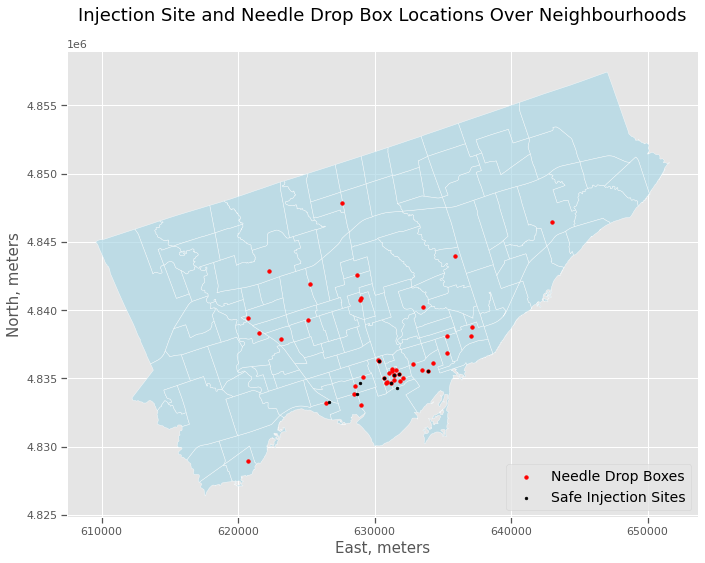

In [197]:
# Plot all three sets of data
ax= neighbourhoods_26917.plot(figsize=(12, 8), edgecolor='w', color='lightblue', alpha=0.7)
needle_locations_gdf_26917.plot(ax=ax, color='red', marker= 'o', label='Needle Drop Boxes', markersize=14)
injection_locations_gdf_26917.plot(ax=ax, color='black', marker= 'o', label='Safe Injection Sites', markersize=8)

# Add a legend
plt.legend(fontsize = 14, loc=4)

# Set the axis labels
plt.xlabel('East, meters', fontsize=15)
plt.ylabel('North, meters', fontsize=15)
plt.title('Injection Site and Needle Drop Box Locations Over Neighbourhoods', fontsize=18, pad=30)
plt.savefig('plots/injection_site_drop_box_site_over_neighbourhood_map.png', dpi=300)
plt.show()

#### Trends:
It looks like the injection sites are all downtown and the drop boxes are mostly downtown, with some in other neighbourhooods. 

Calculate the area of each neighbourhood in square kilometers  so we can find the density of sites within each neighbourhood.

In [198]:
# Call the geometry.area method to get the area in m2 and divide by 10^6 to convert to km2
neighbourhoods_26917['area'] = round(neighbourhoods_26917.geometry.area / 10 ** 6,3)

neighbourhoods_26917.head()

,neighbourhood_name,geometry,area
0,Wychwood,"POLYGON ((626071.503 4837537.756, 626151.708 4...",1.682
1,Yonge-Eglinton,"POLYGON ((628032.302 4840233.689, 628139.346 4...",1.650
2,Yonge-St.Clair,"POLYGON ((629674.232 4837709.743, 629657.497 4...",1.161
3,York University Heights,"POLYGON ((620320.085 4846288.688, 620352.534 4...",13.247
4,Yorkdale-Glen Park,"POLYGON ((625714.291 4840359.316, 625680.263 4...",6.038


Calcualte the denisty of injection sites or drop boxes per square kilometre.

In [230]:
# Apply the .within() method to each row in the neighbourhoods geodataframe to determine number of sites in each neighbourhood
neighbourhoods_26917['sites'] = neighbourhoods_26917.apply(lambda row: (needle_locations_gdf_26917.geometry.within(row.geometry).sum() + 
                                                            injection_locations_gdf_26917.geometry.within(row.geometry).sum()), axis=1)

# Sort the geodataframe by the stations
neighbourhoods_26917 = neighbourhoods_26917.sort_values(by='sites', ascending = False)

# Divide the number of stations in each neighbourhood by the area of each neighbourhood
neighbourhoods_26917['site_density'] = round(neighbourhoods_26917['sites'] / neighbourhoods_26917['area'],3)

# View GeoDataFrame
neighbourhoods_26917.head(12)

,neighbourhood_name,geometry,area,sites,site_density
18,Moss Park,"POLYGON ((632910.604 4834938.350, 632883.548 4...",1.413,11,7.785
97,Church-Yonge Corridor,"POLYGON ((630881.766 4835659.785, 630893.584 4...",1.365,7,5.128
49,South Riverdale,"POLYGON ((634788.020 4834074.432, 634789.475 4...",10.965,4,0.365
39,Regent Park,"POLYGON ((632697.229 4835190.362, 632679.479 4...",0.650,3,4.615
136,Kensington-Chinatown,"POLYGON ((628713.653 4833925.535, 628698.164 4...",1.535,3,1.954
109,East End-Danforth,"POLYGON ((635984.455 4838346.643, 635968.842 4...",2.639,2,0.758
61,Waterfront Communities-The Island,"POLYGON ((630894.760 4833934.115, 630991.159 4...",13.416,2,0.149
26,Niagara,"POLYGON ((626833.621 4831957.033, 626830.404 4...",3.241,2,0.617
48,South Parkdale,"POLYGON ((626833.621 4831957.033, 626695.520 4...",2.287,2,0.875
1,Yonge-Eglinton,"POLYGON ((628032.302 4840233.689, 628139.346 4...",1.650,2,1.212


Visualize the resutls to see the variance in location density.

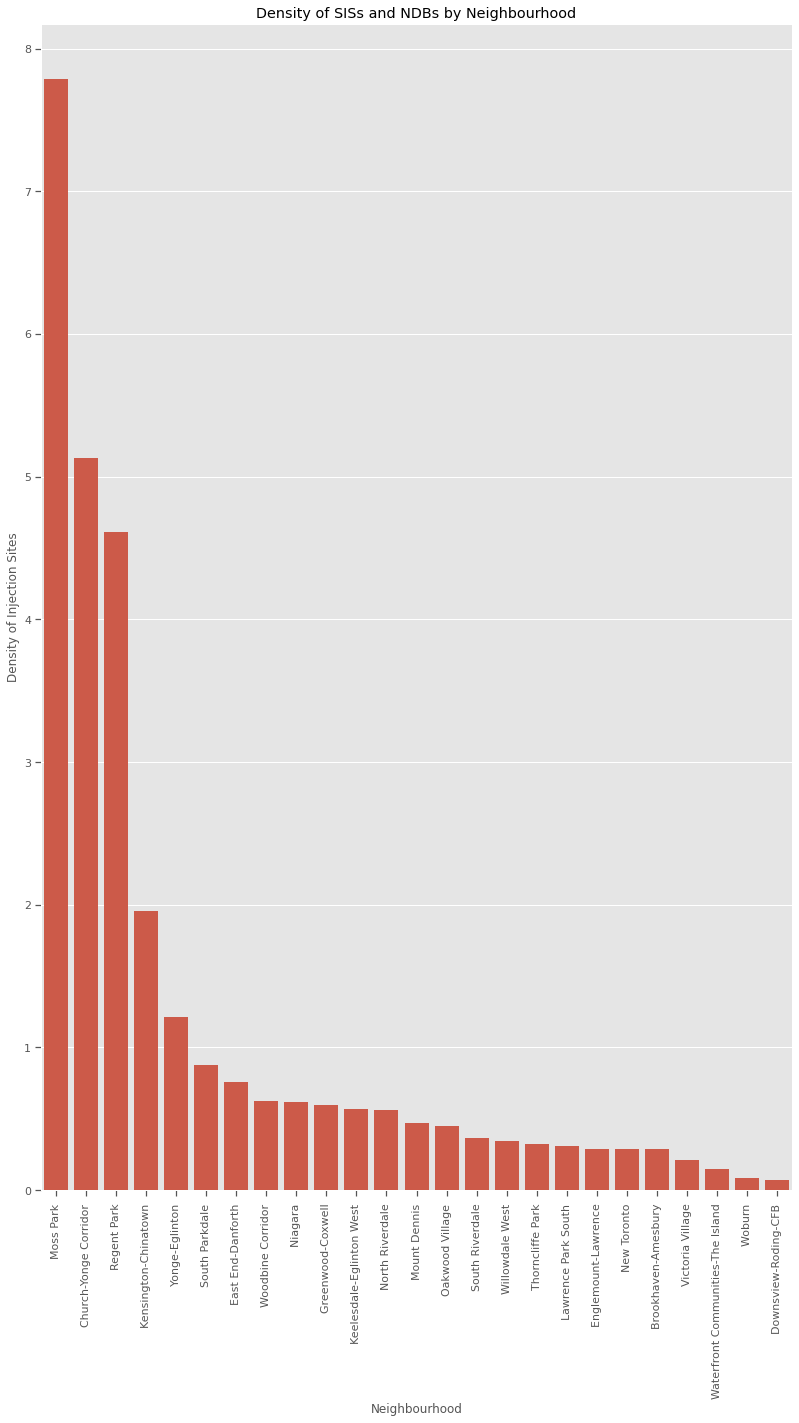

In [234]:
# Visualize only the neighbourhoods with injeciton or drop box sites
neighbourhoods_with_sites = neighbourhoods_26917[neighbourhoods_26917['sites']>0].sort_values(by='site_density',ascending = False)
fig, ax = plt.subplots(figsize=(12, 20))
sns.barplot(neighbourhoods_with_sites, x='neighbourhood_name', y='site_density')
plt.ylabel('Density of Injection Sites')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=90)
plt.title('Density of SISs and NDBs by Neighbourhood')
plt.savefig('plots/Injection_site_density_by_neighbourhood.png', dpi=300)
plt.show()

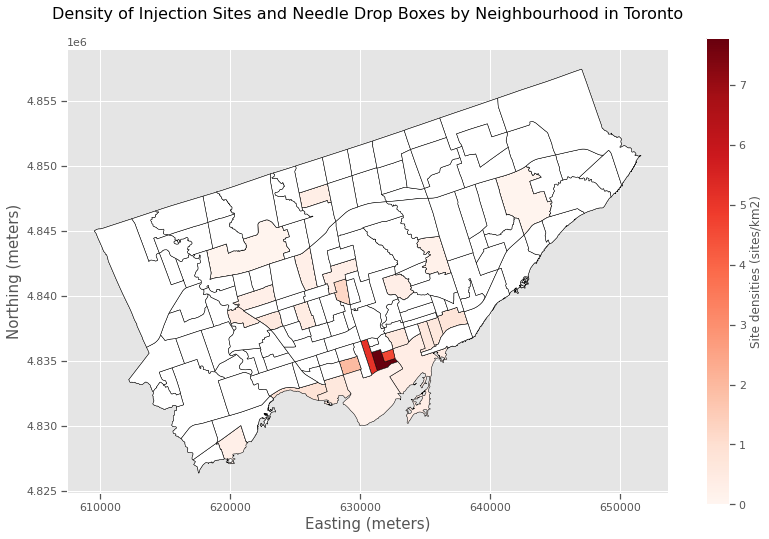

In [219]:
# Plot choropleth map for green space percentage
fig, ax = plt.subplots(figsize=(12, 8))
neighbourhoods_26917.plot(
    column="site_density",  # Use the green space percentage column
    cmap="Reds",  # Color scheme
    linewidth=0.5,  # Line width for ward boundaries
    edgecolor="black",  # Edge color for ward boundaries
    legend=True,  # Add legend
    legend_kwds={"label": "Site densities (sites/km2)"},
    ax=ax,  # Axis to plot on
    vmin=0,
    vmax=neighbourhoods_26917['site_density'].max()
)

# Separate zero density areas
mask_zero = neighbourhoods_26917['site_density'] == 0

# Overlay zero density areas in white
neighbourhoods_26917[mask_zero].plot(
    color="white",  # Set color to white for zero density
    linewidth=0.5,  # Line width for boundaries
    edgecolor="black",  # Edge color for boundaries
    ax=ax,  # Axis to plot on
)
plt.title("Density of Injection Sites and Needle Drop Boxes by Neighbourhood in Toronto", fontsize=16, pad=30)
plt.xlabel("Easting (meters)", fontsize=15)
plt.ylabel("Northing (meters)", fontsize=15)
plt.savefig('plots/choropleth_map_site_density.png', dpi=300)
plt.show()

In [202]:
# Save a csv
neighbourhoods_26917_no_geom = neighbourhoods_26917.drop(columns='geometry')
neighbourhoods_26917_no_geom.to_csv('neighbourhood_injection_density.csv')

# Review the sold properties from Zillow

Read and review the csv and group the properties into neighbourhoods so an average neighbourhood price can be calculated.

In [203]:
# Read and view the zillow_coordinates.csv file into a dataframe
properties = pd.read_csv("zillow_coordinates.csv")
properties.head()

,address,price,link,bedrooms,bathrooms,cleaned_address,Latitude,Longitude
0,"2240 Lake Shore Blvd W #1701, Toronto, ON M8V 0B1","C$710,000",https://www.zillow.com/homedetails/2240-Lake-S...,--,--,"2240 Lake Shore Blvd W. , ON",43.621242,-79.483024
1,"11 Saint Joseph St N, Toronto, ON M4Y 3G4","C$532,000",https://www.zillow.com/homedetails/11-Saint-Jo...,--,--,"11 Saint Joseph St N., ON",29.943809,-90.069620
2,"899 Queen St E #409, Toronto, ON M4M 0C8","C$893,000",https://www.zillow.com/homedetails/899-Queen-S...,--,--,"899 Queen St E. , ON",43.660515,-79.341890
3,"49 E Liberty St #2508, Toronto, ON M6K 0A7","C$620,000",https://www.zillow.com/homedetails/49-E-Libert...,2,1,"49 E. Liberty St , ON",43.638846,-79.412554
4,"91 Drayton Ave, Toronto, ON M4C 3L8",$1.22M,https://www.zillow.com/homedetails/91-Drayton-...,--,--,"91 Drayton Ave, ON",43.681648,-79.318933


The only needed columns are 'price', 'Latitude', and 'Longitude'.

In [204]:
# Extract only the useful columns
properties=properties[['price', 'Latitude', 'Longitude']]
properties.head()

,price,Latitude,Longitude
0,"C$710,000",43.621242,-79.483024
1,"C$532,000",29.943809,-90.069620
2,"C$893,000",43.660515,-79.341890
3,"C$620,000",43.638846,-79.412554
4,$1.22M,43.681648,-79.318933


We must also convert the properties' latitudes and longitudes into GeoDataFrame point locations.

In [205]:
# Convert dataframe into a GeoDataFrame by specifying the latitude and longitude
properties_geo = gpd.GeoDataFrame(properties, 
                                    geometry=gpd.points_from_xy(properties['Longitude'], properties['Latitude']),crs="EPSG:4326")

# Ensure they use the epsg=26917 CRS
properties_geo=properties_geo.to_crs(epsg=26917)

In [206]:
properties_geo.head()

,price,Latitude,Longitude,geometry
0,"C$710,000",43.621242,-79.483024,POINT (622393.975 4830924.404)
1,"C$532,000",29.943809,-90.069620,POINT (-377081.485 3347393.464)
2,"C$893,000",43.660515,-79.341890,POINT (633694.013 4835503.876)
3,"C$620,000",43.638846,-79.412554,POINT (628042.348 4832985.800)
4,$1.22M,43.681648,-79.318933,POINT (635497.501 4837888.204)


Now, perform spatial analysis to determine which neighbourhood each sold property is in.

In [207]:
# Use .sjoin to determine which neighbouhoods the properties are within
properties_gdf = gpd.sjoin(properties_geo, neighbourhoods_26917[['geometry','neighbourhood_name']], how='left', op='within')
# Drop the "index_right" column
properties_gdf=properties_gdf.drop(columns=['index_right'])
# View the GeoDataFrame
properties_gdf.head()

,price,Latitude,Longitude,geometry,neighbourhood_name
0,"C$710,000",43.621242,-79.483024,POINT (622393.975 4830924.404),Mimico
1,"C$532,000",29.943809,-90.069620,POINT (-377081.485 3347393.464),NaN
2,"C$893,000",43.660515,-79.341890,POINT (633694.013 4835503.876),South Riverdale
3,"C$620,000",43.638846,-79.412554,POINT (628042.348 4832985.800),Niagara
4,$1.22M,43.681648,-79.318933,POINT (635497.501 4837888.204),Woodbine Corridor


In [208]:
properties_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 318 entries, 0 to 317
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   price               318 non-null    object  
 1   Latitude            318 non-null    float64 
 2   Longitude           318 non-null    float64 
 3   geometry            318 non-null    geometry
 4   neighbourhood_name  307 non-null    object  
dtypes: float64(2), geometry(1), object(2)
memory usage: 14.9+ KB


Note: The "price" column is currently an object type. To perform EDA with the average neighbourhood selling price, the "price" column must be converted to a numeric value. Clean the data by extracting characters such as "$", "C", ",".

In [209]:
def cleaned_price(price_row):
    # If the price is already a numeric value, return the value
    if isinstance(price_row, (int, float)):
        return price_row
    
    # If the price is a string, clean it
    if isinstance(price_row, str):
        # Remove 'C','$', and ','
        price_row = price_row.replace(',', '')
        price_row = price_row.replace('C', '')
        price_row = price_row.replace('$', '')
        price_row = price_row.strip()
        
        # Check if price contains 'M' for millions or 'K' for thousands
        if 'M' in price_row:
            price_row = float(price_row.replace('M', '')) * 1000000
        elif 'K' in price_row:
            price_row = float(price_row.replace('K', '')) * 1000
        else:
            try:
                # Convert to float if no 'M' or 'K'
                price_row = float(price_row)
            except ValueError:
                # Return Nan if it can't be converted
                price_row = float('nan')
    
    return price_row

# Apply the function to the 'price' column
properties_gdf['price'] = properties_gdf['price'].apply(cleaned_price)

In [210]:
# Vew the updated gdf
properties_gdf.head()

,price,Latitude,Longitude,geometry,neighbourhood_name
0,710000.0,43.621242,-79.483024,POINT (622393.975 4830924.404),Mimico
1,532000.0,29.943809,-90.069620,POINT (-377081.485 3347393.464),NaN
2,893000.0,43.660515,-79.341890,POINT (633694.013 4835503.876),South Riverdale
3,620000.0,43.638846,-79.412554,POINT (628042.348 4832985.800),Niagara
4,1220000.0,43.681648,-79.318933,POINT (635497.501 4837888.204),Woodbine Corridor


Review if any values returned Nan

In [211]:
properties_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 318 entries, 0 to 317
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   price               310 non-null    float64 
 1   Latitude            318 non-null    float64 
 2   Longitude           318 non-null    float64 
 3   geometry            318 non-null    geometry
 4   neighbourhood_name  307 non-null    object  
dtypes: float64(3), geometry(1), object(1)
memory usage: 14.9+ KB


There are Nan values in "price" and "neighbourhood_name". Remove these rows for further processing.

In [212]:
# Drop Nan rows
properties_gdf=properties_gdf.dropna()

Now that we have a clean dataframe with prices and appropriate neighbourhood names, group the dataframe by the neighbourhood names and take the average of the sold prices for each neighbourhood. The average neighbourhood sold price will account for the variance in size of home, as the price is already a factor of the internal characteristics of the home (size, # of bedrooms, # of bathrooms). This analysis assumes that there is equal proportion of variance in home size accross all neighbourhoods.?????

In [213]:
properties_in_neighbourhoods = properties_gdf.groupby(['neighbourhood_name'])[['price']].mean()
properties_in_neighbourhoods['price'] = round(properties_in_neighbourhoods['price'],0)
properties_in_neighbourhoods

,price
neighbourhood_name,
Agincourt North,990000.0
Agincourt South-Malvern West,1298000.0
Alderwood,1560000.0
Annex,2108571.0
Banbury-Don Mills,1990000.0
...,...
Woodbine Corridor,1277500.0
Woodbine-Lumsden,1370000.0
Wychwood,1620000.0


In [214]:
merged_df=pd.merge(properties_in_neighbourhoods, neighbourhoods_26917, on='neighbourhood_name').drop(columns='geometry')
merged_df.head(30)

,neighbourhood_name,price,area,sites,site_density
0,Agincourt North,990000.0,7.262,0,0.000
1,Agincourt South-Malvern West,1298000.0,7.873,0,0.000
2,Alderwood,1560000.0,4.978,0,0.000
3,Annex,2108571.0,2.790,0,0.000
4,Banbury-Don Mills,1990000.0,10.042,0,0.000
5,Bathurst Manor,1980000.0,4.760,0,0.000
6,Bay Street Corridor,1140000.0,1.809,0,0.000
7,Bayview Village,2050000.0,5.159,0,0.000
8,Bedford Park-Nortown,3133333.0,5.518,0,0.000
9,Bendale,1104500.0,7.457,0,0.000


In [215]:
merged_df=merged_df[merged_df['site_density']>0]
correlation = merged_df['price'].corr(merged_df['site_density'])
correlation

-0.1586802988036679

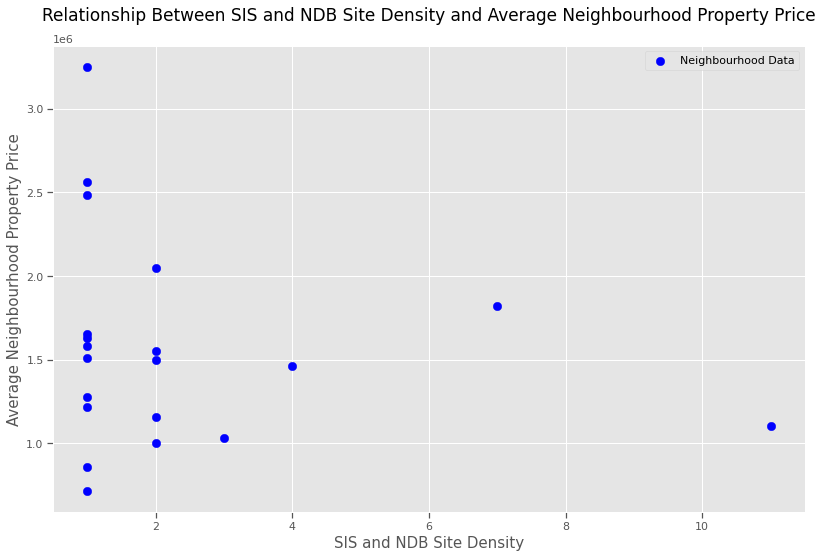

In [238]:
plt.figure(figsize=(12, 8))
plt.scatter(merged_df['sites'], merged_df['price'], label='Neighbourhood Data', s=70, color='blue')
plt.xlabel('SIS and NDB Site Density', fontsize=15)
plt.ylabel('Average Neighbourhood Property Price', fontsize=15)
plt.title('Relationship Between SIS and NDB Site Density and Average Neighbourhood Property Price', pad=25, fontsize=17)
plt.legend()
plt.savefig('plots/Price_vs_Site_Density_Scatterplot.png', dpi=300)
plt.show()

Look at how

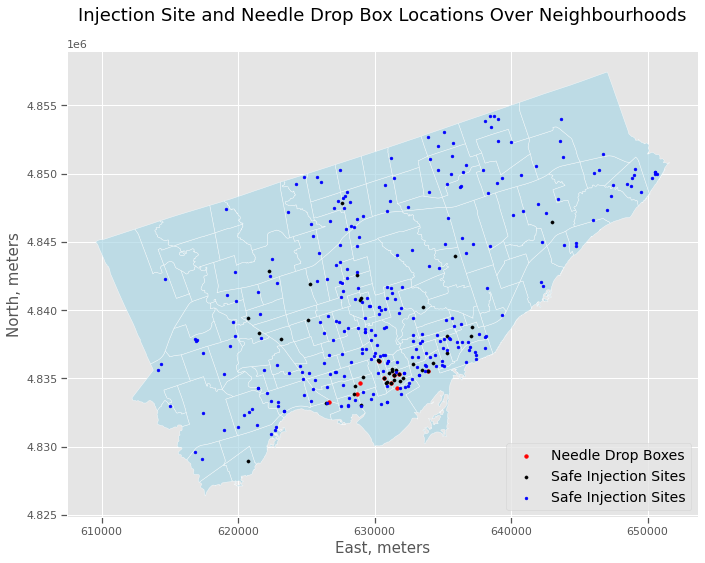

In [138]:
# Plot all three sets of data
ax= neighbourhoods_26917.plot(figsize=(12, 8), edgecolor='w', color='lightblue', alpha=0.7)
needle_locations_gdf_26917.plot(ax=ax, color='red', marker= 'o', label='Needle Drop Boxes', markersize=14)
injection_locations_gdf_26917.plot(ax=ax, color='black', marker= 'o', label='Safe Injection Sites', markersize=10)
properties_gdf.plot(ax=ax, color='blue', marker= 'o', label='Safe Injection Sites', markersize=8)

# Add a legend
plt.legend(fontsize = 14, loc=4)

# Set the axis labels
plt.xlabel('East, meters', fontsize=15)
plt.ylabel('North, meters', fontsize=15)
plt.title('Injection Site and Needle Drop Box Locations Over Neighbourhoods', fontsize=18, pad=30)
plt.show()

In [139]:
needle_locations_gdf_26917['buffer'] = needle_locations_gdf_26917.geometry.buffer(800)


In [140]:
properties_geo['with buffer'] = properties_geo.geometry.apply(lambda x:
                                                               any(x.intersects(buffer) for buffer in needle_locations_gdf_26917['buffer']))

In [141]:
properties_geo.head()

,price,Latitude,Longitude,geometry,with buffer
0,"C$710,000",43.621242,-79.483024,POINT (622393.975 4830924.404),False
1,"C$532,000",29.943809,-90.069620,POINT (-377081.485 3347393.464),False
2,"C$893,000",43.660515,-79.341890,POINT (633694.013 4835503.876),True
3,"C$620,000",43.638846,-79.412554,POINT (628042.348 4832985.800),False
4,$1.22M,43.681648,-79.318933,POINT (635497.501 4837888.204),False


In [142]:
properties_geo['with buffer'].sum()

29

In [154]:
intersecting_properties = properties_geo[properties_geo['with buffer']==True].reset_index(drop=True)
non_intersecting_properties = properties_geo[properties_geo['with buffer']==False].reset_index(drop=True)

In [155]:
# Use .sjoin to determine which neighbouhoods the properties are within
intersecting_properties_joined = gpd.sjoin(intersecting_properties, neighbourhoods_26917[['geometry','neighbourhood_name']], how='left', op='within')
# Drop the "index_right" column
# intersecting_properties_joined=intersecting_properties_joined.drop(columns=['index_right'])
# # View the GeoDataFrame
intersecting_properties_joined.head()

,price,Latitude,Longitude,geometry,with buffer,index_right,neighbourhood_name
0,"C$893,000",43.660515,-79.341890,POINT (633694.013 4835503.876),True,49,South Riverdale
1,$1.55M,43.671605,-79.387684,POINT (629977.640 4836662.813),True,77,Annex
2,"C$815,000",43.645886,-79.364435,POINT (631908.241 4833843.002),True,61,Waterfront Communities-The Island
3,$1.35M,43.671080,-79.382929,POINT (630362.128 4836611.984),True,97,Church-Yonge Corridor
4,$--,43.643159,-79.428251,POINT (626767.145 4833440.685),True,10,Little Portugal


In [157]:
# Use .sjoin to determine which neighbouhoods the properties are within
non_intersecting_properties_joined = gpd.sjoin(non_intersecting_properties, neighbourhoods_26917[['geometry','neighbourhood_name']], how='left', op='within')
# Drop the "index_right" column
# intersecting_properties_joined=intersecting_properties_joined.drop(columns=['index_right'])
# # View the GeoDataFrame
non_intersecting_properties_joined.head()

,price,Latitude,Longitude,geometry,with buffer,index_right,neighbourhood_name
0,"C$710,000",43.621242,-79.483024,POINT (622393.975 4830924.404),False,16.0,Mimico
1,"C$532,000",29.943809,-90.069620,POINT (-377081.485 3347393.464),False,NaN,NaN
2,"C$620,000",43.638846,-79.412554,POINT (628042.348 4832985.800),False,26.0,Niagara
3,$1.22M,43.681648,-79.318933,POINT (635497.501 4837888.204),False,72.0,Woodbine Corridor
4,"C$990,000",43.681353,-79.324032,POINT (635087.235 4837847.153),False,120.0,Greenwood-Coxwell


In [158]:
# Apply the function to the 'price' column
intersecting_properties_joined['price'] = intersecting_properties_joined['price'].apply(cleaned_price)
non_intersecting_properties_joined['price'] = non_intersecting_properties_joined['price'].apply(cleaned_price)

In [173]:
intersecting_properties_joined = intersecting_properties_joined.groupby(['neighbourhood_name'])[['price']].mean()
intersecting_properties_joined['price'] = round(intersecting_properties_joined['price'],0)
intersecting_properties_joined

,price
neighbourhood_name,
Annex,1830000.0
Bay Street Corridor,1140000.0
Church-Yonge Corridor,1823333.0
Moss Park,1730000.0
Niagara,1575000.0
North St.James Town,1029293.0
Regent Park,1031400.0
Rosedale-Moore Park,1313333.0
South Parkdale,1500000.0


In [174]:
non_intersecting_properties_joined = non_intersecting_properties_joined.groupby(['neighbourhood_name'])[['price']].mean()
non_intersecting_properties_joined['price_non'] = round(non_intersecting_properties_joined['price'],0)
non_intersecting_properties_joined

,price,price_non
neighbourhood_name,,
Agincourt North,990000.0,990000.0
Agincourt South-Malvern West,1298000.0,1298000.0
Alderwood,1560000.0,1560000.0
Annex,2220000.0,2220000.0
Banbury-Don Mills,1990000.0,1990000.0
...,...,...
Woodbine Corridor,1277500.0,1277500.0
Woodbine-Lumsden,1370000.0,1370000.0
Wychwood,1620000.0,1620000.0


In [175]:
intersecting_properties_joined=intersecting_properties_joined.dropna()
non_intersecting_properties_joined=non_intersecting_properties_joined.dropna()

In [176]:
merged_intersection = pd.merge(intersecting_properties_joined, non_intersecting_properties_joined, on='neighbourhood_name', how='inner')
merged_intersection.head()

,price_x,price_y,price_non
neighbourhood_name,,,
Annex,1830000.0,2220000.0,2220000.0
Moss Park,1730000.0,478500.0,478500.0
Niagara,1575000.0,945000.0,945000.0
Rosedale-Moore Park,1313333.0,2205000.0,2205000.0
South Riverdale,1443833.0,1492500.0,1492500.0


In [178]:
correlation = merged_intersection['price_x'].corr(merged_intersection['price_y'])
correlation

0.06220692080347513

In [147]:
non_intersecting_properties_joined = gpd.sjoin(non_intersecting_properties, neighbourhoods_26917[['geometry','neighbourhood_name']], how='left', op='within')
# Drop the "index_right" column
# intersecting_properties_joined=intersecting_properties_joined.drop(columns=['index_right'])
# # View the GeoDataFrame
non_intersecting_properties_joined.head()

,price,Latitude,Longitude,geometry,with buffer,index_right,neighbourhood_name
0,"C$710,000",43.621242,-79.483024,POINT (622393.975 4830924.404),False,16.0,Mimico
1,"C$532,000",29.943809,-90.069620,POINT (-377081.485 3347393.464),False,NaN,NaN
3,"C$620,000",43.638846,-79.412554,POINT (628042.348 4832985.800),False,26.0,Niagara
4,$1.22M,43.681648,-79.318933,POINT (635497.501 4837888.204),False,72.0,Woodbine Corridor
6,"C$990,000",43.681353,-79.324032,POINT (635087.235 4837847.153),False,120.0,Greenwood-Coxwell
